In [104]:
import networkx as nx
import numpy as np
from queue import PriorityQueue
import ipywidgets as widgets
from copy import deepcopy
import torch
from utils import *
import torch.nn as nn
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, HTML
import logging

In [37]:


# Configure logging to output to PyCharm's console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

def add_node_with_edges(graph, node_name):
    """
    Add a node to the graph and allow the user to input related edges with direction using widgets in Jupyter Notebook.
    Displays immediate edge information on addition and logs actions to console.

    Parameters:
    graph (nx.DiGraph): The directed graph to add the node and edges to.
    node_name (str): The name of the node to add.

    Returns:
    None
    """
    # Add the node to the graph
    graph.add_node(node_name)
    display(HTML(f"<b>Notification:</b> Node '{node_name}' has been added to the graph."))
    logger.info(f"Node '{node_name}' has been added to the graph.")

    # Define output widget
    global node_dropdown, user_text, root_text, direction_dropdown, output
    output = widgets.Output()

    # Function to handle edge addition
    def add_edge(b):
        with output:
            clear_output(wait=True)
            display(HTML(f"<b>Notification:</b> Node '{node_name}' has been added to the graph."))
            logger.info(f"Add Edge button clicked for node '{node_name}'.")
            
            try:
                # Get widget values
                target_node = node_dropdown.value
                user_prob = float(user_text.value)
                root_prob = float(root_text.value)
                direction = direction_dropdown.value
                
                # Validate probabilities
                if not (0.0 <= user_prob <= 1.0 and 0.0 <= root_prob <= 1.0):
                    display(HTML("<b>Error:</b> Probabilities must be in the range [0.0, 1.0]. Please try again."))
                    logger.error(f"Invalid probabilities: user={user_prob}, root={root_prob}")
                    return
                
                # Prepare edge information
                edge_info = f"Edge Info: user={user_prob}, root={root_prob}, direction={direction}"
                
                # Add edge based on direction
                if direction == "To Target":
                    graph.add_edge(node_name, target_node, user=user_prob, root=root_prob)
                    edge_msg = f"Edge from '{node_name}' to '{target_node}' ({edge_info})"
                elif direction == "From Target":
                    graph.add_edge(target_node, node_name, user=user_prob, root=root_prob)
                    edge_msg = f"Edge from '{target_node}' to '{node_name}' ({edge_info})"
                else:  # Bidirectional
                    graph.add_edge(node_name, target_node, user=user_prob, root=root_prob)
                    graph.add_edge(target_node, node_name, user=user_prob, root=root_prob)
                    edge_msg = f"Bidirectional edge between '{node_name}' and '{target_node}' ({edge_info})"
                
                # Display and log edge info immediately
                display(HTML(f"<b>Notification:</b> {edge_msg} has been added."))
                logger.info(f"{edge_msg} has been added.")
                display_widgets()  # Redisplay widgets for next edge
            except ValueError:
                display(HTML("<b>Error:</b> Invalid input for probabilities. Please enter valid numbers."))
                logger.error("Invalid input for probabilities.")

    # Function to handle stopping
    def stop_adding(b):
        with output:
            clear_output(wait=True)
            display(HTML(f"<b>Notification:</b> Finished adding edges for node '{node_name}'."))
            logger.info(f"Finished adding edges for node '{node_name}'.")

    # Function to display widgets
    def display_widgets():
        with output:
            clear_output(wait=True)
            # Get list of existing nodes
            existing_nodes = list(graph.nodes())
            if not existing_nodes:
                display(HTML("<b>Warning:</b> No existing nodes in the graph."))
                logger.warning("No existing nodes in the graph.")
                return
            
            # Create widgets
            global node_dropdown, user_text, root_text, direction_dropdown
            node_dropdown = widgets.Dropdown(
                options=existing_nodes,
                description='Target Node:',
                disabled=False
            )
            user_text = widgets.FloatText(
                value=0.0,
                description='User Prob:',
                style={'description_width': 'initial'}
            )
            root_text = widgets.FloatText(
                value=0.0,
                description='Root Prob:',
                style={'description_width': 'initial'}
            )
            direction_dropdown = widgets.Dropdown(
                options=["To Target", "From Target", "Bidirectional"],
                description='Edge Direction:',
                disabled=False
            )
            add_button = widgets.Button(description="Add Edge")
            stop_button = widgets.Button(description="Stop")

            # Assign button callbacks with debug logging
            def on_add_button_clicked(b):
                logger.info("Add Edge button event triggered.")
                add_edge(b)
            
            def on_stop_button_clicked(b):
                logger.info("Stop button event triggered.")
                stop_adding(b)

            add_button.on_click(on_add_button_clicked)
            stop_button.on_click(on_stop_button_clicked)

            # Display widgets and initial message
            display(HTML(f"<b>Adding edges from/to '{node_name}':</b>"))
            display(node_dropdown, user_text, root_text, direction_dropdown, add_button, stop_button)

    # Initial display of widgets
    display(output)
    display_widgets()

In [38]:
# Original graph setup
G_original = nx.DiGraph()
edges = [
    ("Attacker", "Pad", {"user": 0.6, "root": 0.6}),
    ("Attacker", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Attacker", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Pad", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Pad", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Pad", {"user": 0.6, "root": 0.6}),
    ("Host 1", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Host 1", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Host 2", "Host 3", {"user": 0.8, "root": 0.8}),
    ("Host 2", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 2", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Host 2", {"user": 0.8, "root": 0.8}),
    ("Host 3", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Web Server", "File Server", {"user": 0.8, "root": 0.04}),
    ("Web Server", "Data Server", {"user": 0.8, "root": 0.04}),
    ("File Server", "Data Server", {"user": 0.8, "root": 0.04})
]
G_original.add_edges_from(edges)

G_new = G_original.copy()
add_node_with_edges(G_new, "New node")



2025-05-30 21:18:27,444 - INFO - Node 'New node' has been added to the graph.


Output()

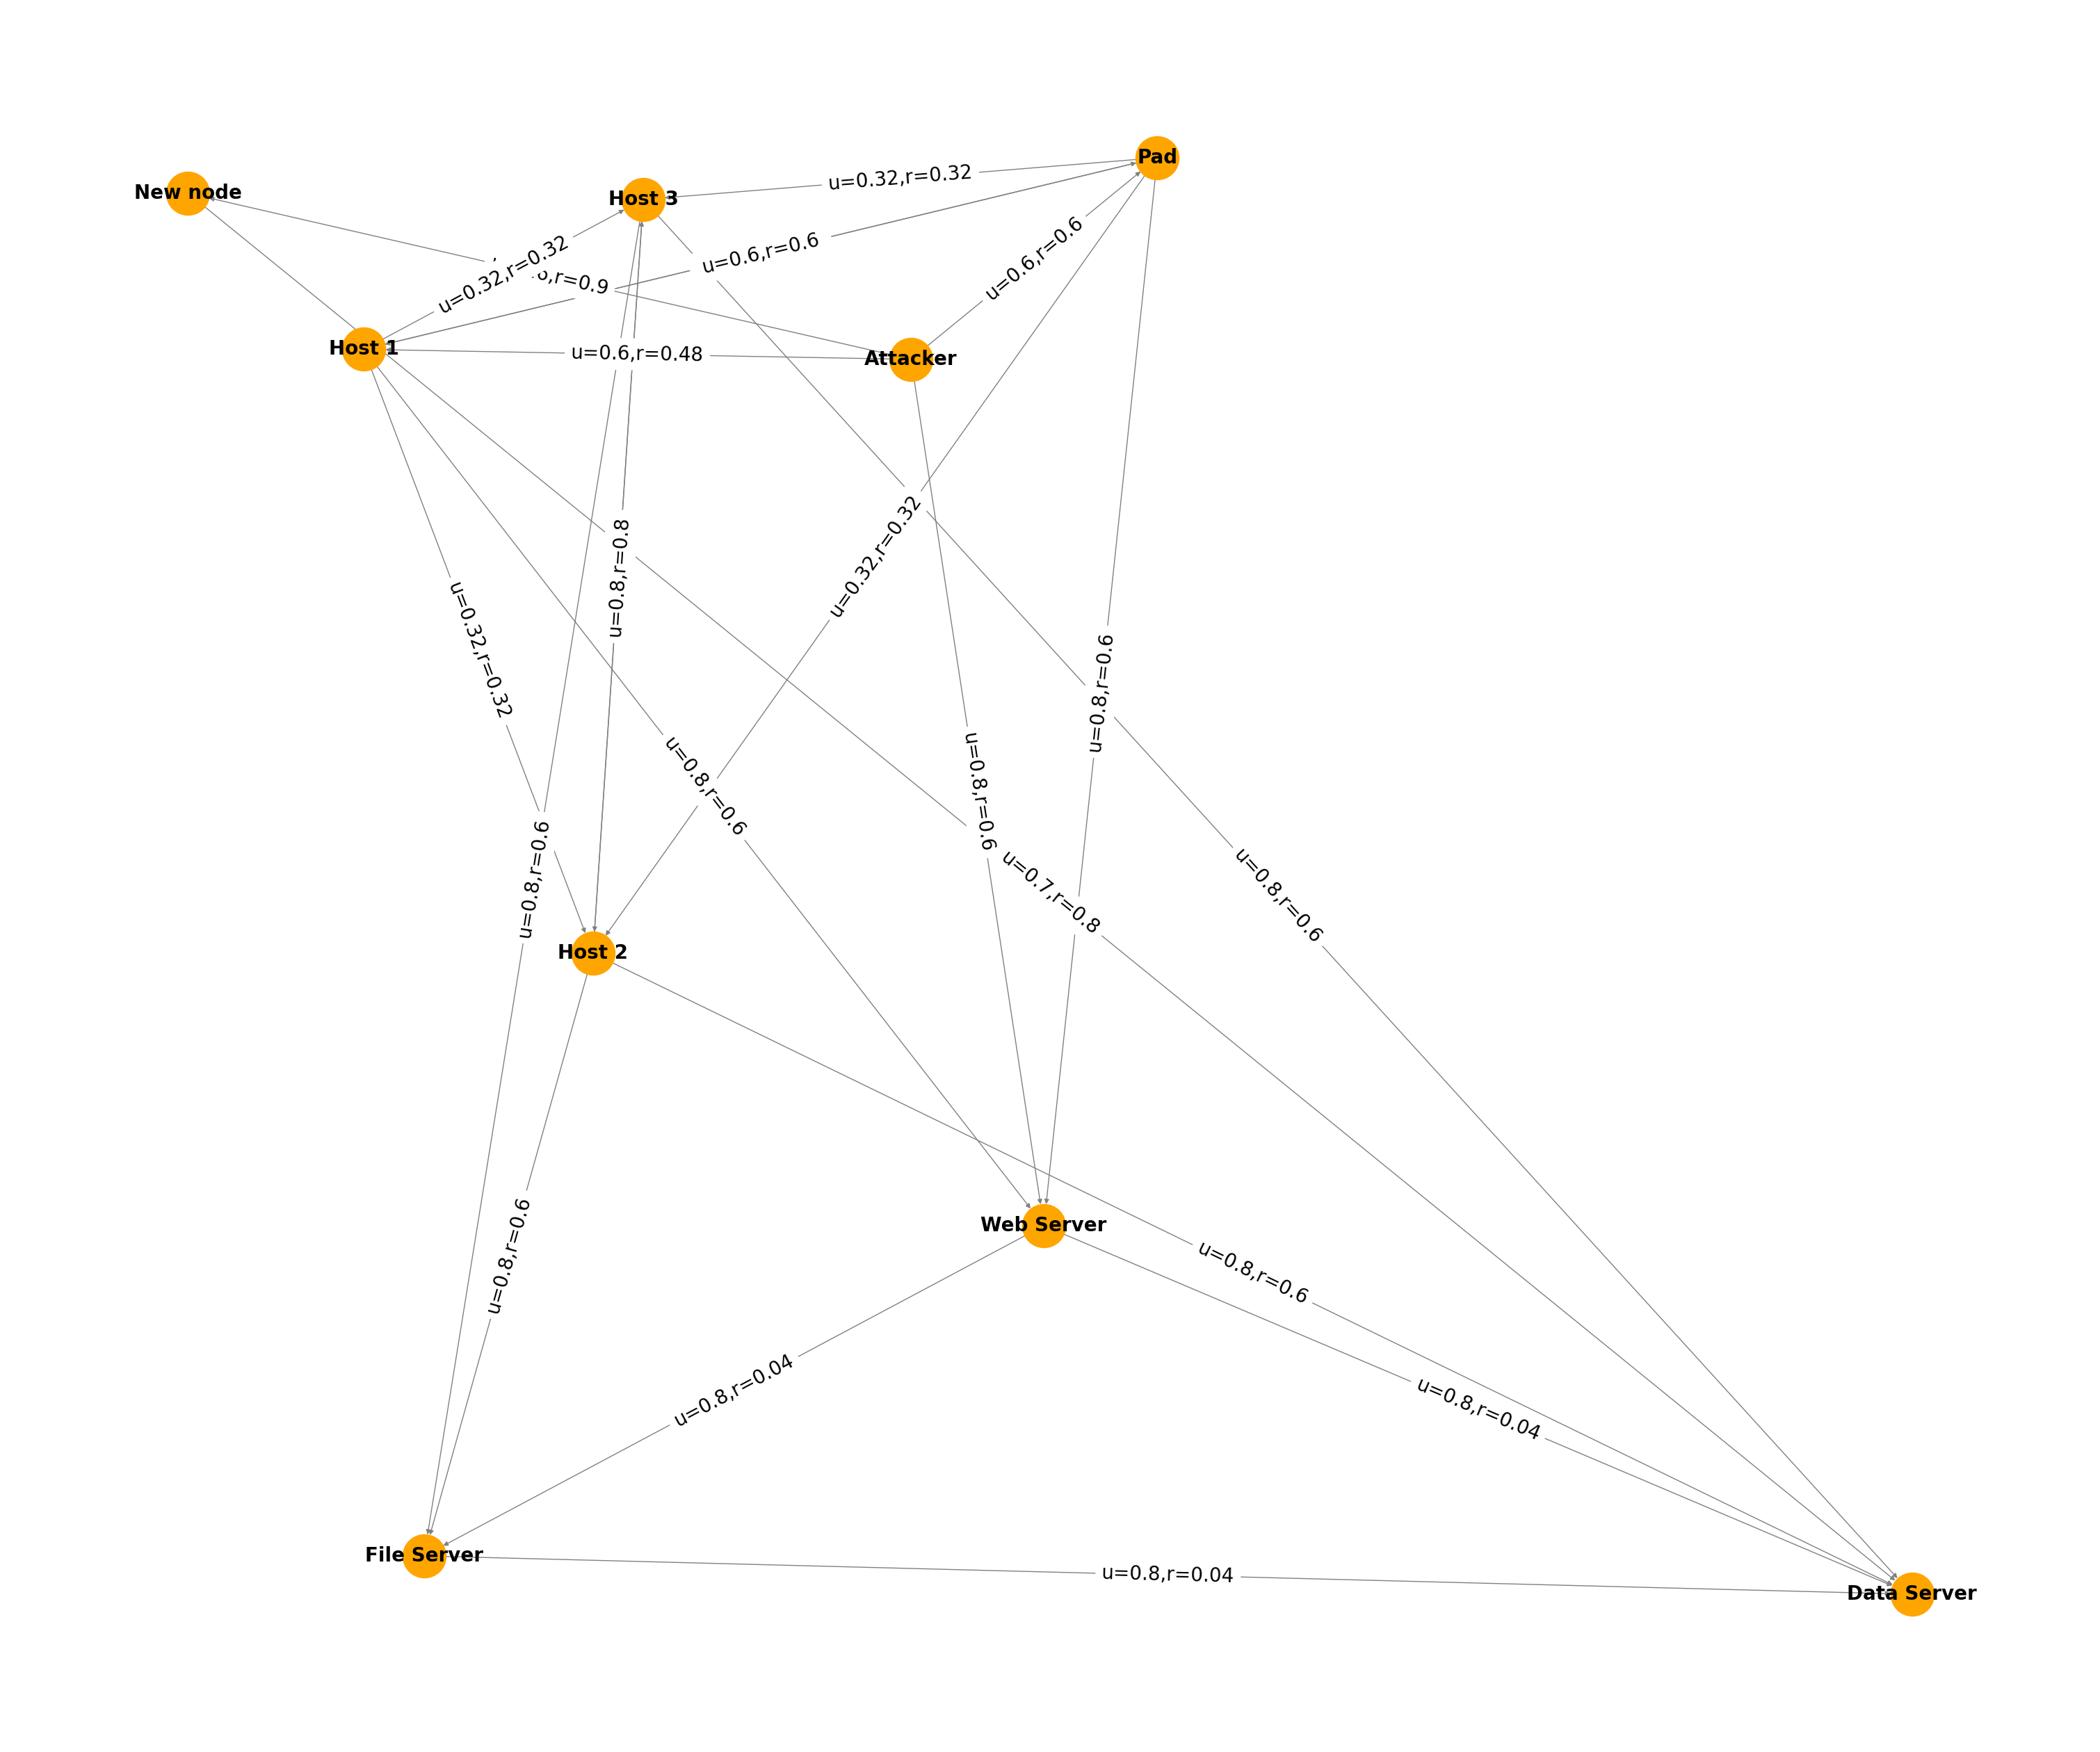

In [39]:

# Draw the graph
plt.figure(figsize=(30,25))
pos = nx.spring_layout(G_new)

nx.draw(G_new, pos, with_labels=True, node_color='orange', edge_color='gray', node_size=2000, font_size=20, font_weight='bold')

# Draw edge labels with weights
edge_labels = {(u, v): f"u={d['user']},r={d['root']}" for u, v, d in G_new.edges(data=True)}
nx.draw_networkx_edge_labels(G_new, pos, edge_labels=edge_labels, font_size=20)
plt.savefig("graph.png")
plt.show()

In [40]:
class DQNWithBias(nn.Module):
    def __init__(self, base_model, old_space_size, new_space_size):
        super().__init__()
        self.model = base_model
        self.old_space_size = old_space_size
        self.new_space_size = new_space_size
        self.alpha = nn.Parameter(torch.Tensor([1]))
        self.beta = nn.Parameter(torch.Tensor([0]))

    def forward(self, x):
        q_raw = self.model(x)  
        q_old = q_raw[:, :self.old_space_size]  # Action cũ
        q_new = q_raw[:, self.old_space_size:]  # Action mới
        q_new_corrected = self.alpha * q_new + self.beta
        q_corrected = torch.cat([q_old, q_new_corrected], dim=1)
        return q_corrected


In [105]:
old_num_nodes = 6
new_num_nodes = 7
old_action_space_size = old_num_nodes * (old_num_nodes)
new_action_space_size = new_num_nodes * (new_num_nodes)
model_old =  DQN(old_num_nodes, old_action_space_size)
model_load = torch.load("./Saved_Model/dqn_model.pth")
model_old.load_state_dict(model_load['policy_net_state_dict'])
model_new = DQN(new_num_nodes, new_action_space_size)

with torch.no_grad():
   # Copy từ model cũ
    model_new.fc1.weight[:, :old_num_nodes] = model_old.fc1.weight[:, :old_num_nodes]
    model_new.fc1.bias.copy_(model_old.fc1.bias)

    model_new.fc2.load_state_dict(model_old.fc2.state_dict())
    model_new.fc3.load_state_dict(model_old.fc3.state_dict())

    model_new.fc4.weight[:old_action_space_size] = model_old.fc4.weight[:old_action_space_size]
    model_new.fc4.bias[:old_action_space_size] = model_old.fc4.bias[:old_action_space_size]

    # Init phần mới
    torch.nn.init.xavier_uniform_(model_new.fc1.weight[:, old_num_nodes:])
    torch.nn.init.xavier_uniform_(model_new.fc4.weight[old_action_space_size:])
    model_new.fc4.bias[old_action_space_size:] = 0.0



In [110]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Khởi tạo môi trường và mô hình
env = NetworkSecurityEnv(G_new, global_weighted_random_attack)
model = DQNWithBias(model_new, old_action_space_size, new_action_space_size)

# # Chỉ fine-tune tầng cuối (fc4)
for name, param in model.model.named_parameters():
   if not ("fc4" in name or "fc1" in name):
        param.requires_grad = False

optimizer = torch.optim.SGD([
    {'params': [model.alpha], 'weight_decay': 0.0},
    {'params': [model.beta], 'weight_decay': 1e-4}
], lr=0.5, momentum = 0.73)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-5)
criterion = nn.CrossEntropyLoss()


replay_buffer = ReplayBuffer(capacity=10000)



target_update_freq = batch_size = 8
num_episodes = batch_size * 20
losses = []

alpha_history = []
beta_history = []
episode_history = []

epsilon = 0.4
epsilon_min = 0.01
epsilon_decay = 0.9
successes = 0
for episode in range(1, num_episodes + 1):
    state = env.reset()
    done = False
    total_loss = 0
    episode_steps = 0

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)

        if random.random() < epsilon:
            action_idx = sample_exploration_index(new_action_space_size, new_num_nodes, old_action_space_size)
        else:
            with torch.no_grad():
                q_values = model(state_tensor).squeeze(0) 
                if torch.isnan(q_values).any() or torch.isinf(q_values).any():
                    print(f"Warning: NaN or Inf in Q-values at episode {episode}")
                    break
                # Lấy chỉ các index hợp lệ
                valid_indices = [idx for idx in range(new_action_space_size) if is_valid_index(idx, new_num_nodes)]
                valid_q_values = q_values[valid_indices]
                max_idx_in_valid = torch.argmax(valid_q_values).item()
                action_idx = valid_indices[max_idx_in_valid]

        action = index_to_action(action_idx, new_num_nodes)
        next_state, reward, done, path, captured = env.step(action)
        replay_buffer.push(state, action_idx, reward, next_state, done)
        state = next_state
        episode_steps += 1

        honeypot_nodes = []
        for i in range(2):
            node_idx = np.argmax(action[i])
            honeypot_nodes.append(env.nodes[node_idx])

        print("Episode:", episode)
        if reward == 1:
            print(path)
            print(f"Success\nHoneypots: {action}\nHoneypots connected to: {honeypot_nodes}\n")
            successes += 1
        elif reward == -1:
            print(path)
            print(f"Failed\nHoneypots: {action}\nHoneypots connected to: {honeypot_nodes}\n")

        # Train từ buffer
        if len(replay_buffer) >= batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            states_tensor = torch.FloatTensor(states)
            actions_tensor = torch.LongTensor(actions)
            rewards_tensor = torch.FloatTensor(rewards)
            next_states_tensor = torch.FloatTensor(next_states)
            dones_tensor = torch.FloatTensor(dones)

            if not (actions_tensor >= 0).all() or not (actions_tensor < new_action_space_size).all():
                print(f"Invalid actions in batch at episode {episode}")
                continue

            optimizer.zero_grad()
            q_pred = model(states_tensor)

            if torch.isnan(q_pred).any() or torch.isinf(q_pred).any():
                print(f"Warning: NaN or Inf in q_pred at episode {episode}")
                continue

            with torch.no_grad():
                q_next = model(next_states_tensor)
                q_next_max = q_next.max(1)[0]
                q_target = rewards_tensor + (1 - dones_tensor) * 0.99 * q_next_max

            loss = criterion(q_pred, actions_tensor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    avg_loss = total_loss / max(episode_steps, 1)
    if episode >= batch_size:
        losses.append(avg_loss)
        scheduler.step(avg_loss)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)


    if episode % target_update_freq == 0:
        current_lr = optimizer.param_groups[0]['lr']
        alpha_history.append(model.alpha.item())
        beta_history.append(model.beta.item())
        episode_history.append(episode)
    
dsp = (successes / num_episodes) * 100
print(f"\nDefense success probability: {dsp:.2f}%")

Episode: 1
['Attacker', 'Web Server', 'New node', 'File Server', 'Honeypot_0']
Success
Honeypots: [[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 2
['Attacker', 'Web Server', 'Pad', 'New node', 'Honeypot_0']
Success
Honeypots: [[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 3
['Attacker', 'New node', 'Pad', 'Host 3', 'Host 2', 'Host 1', 'File Server', 'Data Server']
Failed
Honeypots: [[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 4
['Attacker', 'Web Server', 'Honeypot_1']
Success
Honeypots: [[0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['File Server', 'Web Server']

Episode: 5
['Attacker', 'Web Server', 'Data Server']
Failed
Honeypots: [[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
Honeypots connected to: ['Host 1', 'Host 2']

Episode: 6
['Attacker', 'Host 1', 'Pad', 'Honeypot_1'

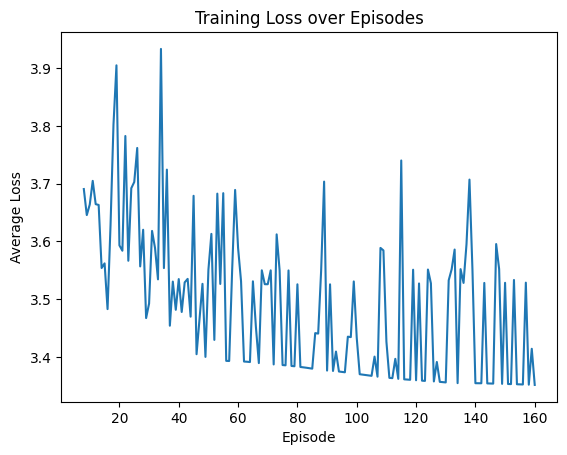

In [111]:
plt.plot(range(batch_size, num_episodes + 1), losses)
plt.xlabel('Episode')
plt.ylabel('Average Loss')
plt.title('Training Loss over Episodes')
plt.show()


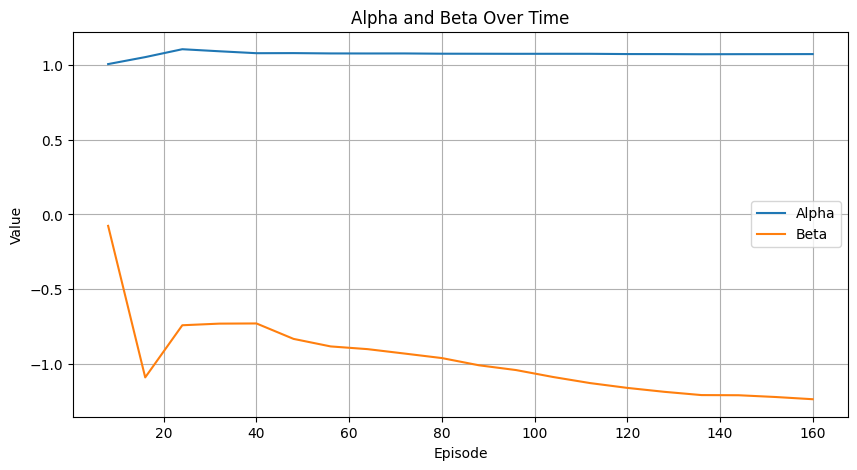

In [112]:
plt.figure(figsize=(10, 5))
plt.plot(episode_history, alpha_history, label='Alpha')
plt.plot(episode_history, beta_history, label='Beta')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Alpha and Beta Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [109]:
evaluate_model(model, env)

Episode: 1
['Attacker', 'New node', 'Host 1', 'Data Server']
Failed
Honeypots: [[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 2
['Attacker', 'New node', 'Data Server']
Failed
Honeypots: [[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 3
['Attacker', 'Web Server', 'Host 1', 'Honeypot_1']
Success
Honeypots: [[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 4
['Attacker', 'Pad', 'Web Server', 'File Server', 'Host 3', 'Host 2', 'Host 1', 'Honeypot_0']
Success
Honeypots: [[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 5
['Attacker', 'New node', 'Web Server', 'Data Server']
Failed
Honeypots: [[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]
Honeypots connected to: ['Web Server', 'Host 1']

Episode: 6
['Attacker', 'Web Server', 'Data Server']
Failed
Honeypots: